# TP Méthodes des différences temporelles -- SARSA et Q-Learning

## Frozen Lake

L'environnement Frozen Lake est un monde grille incertain dans lequel on part depuis un état initial (la case la plus en haut à gauche) pour aller à un état final (la case la plus basse à droite). L'environnement est incertain car vous marchez sur un lac gelé et l'épaisseur de glace varie. Vous pouvez donc tomber dans l'eau dans certaines cases. De plus, la glace est plus glissante à certains endroits, et donc faire un pas peut vous mener plus loin que prévu... et si le vent s'en mèle...

__Actions:__
- LEFT = 0
- DOWN = 1
- RIGHT = 2
- UP = 3

__Reward:__
The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.



Au lieu d'essayer d'estimer le modèle de transition, on va utiliser SARSA et Q-learning pour résoudre ce problème.

Utilisez l'environnement Frozen Lake pour implémenter SARSA et Q-learning. Utilisez d'abord l'environnement avec une grille 4x4 pour tester vos algorithmes, puis vous devriez pouvoir les utiliser pour la grille 16x16.

In [ ]:
https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187  # Q learning explanation

## FrozenLake - familiarisation avec l'environnement

Evaluez une politique aléatoire. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gym
from tqdm import tqdm

In [ ]:
env = gym.make("FrozenLake8x8-v0", is_slippery=True)
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")

env.reset()
nbIt = 0
rew = []
done = False
while not done:
    observation, reward, done, info = env.step(np.random.randint(4))
    env.render()
    nbIt += 1
    rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  64  états et  4  actions
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Episode terminé après 8 itérations
Récompenses obtenues: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## SARSA

### $\epsilon$-greedy

Implémentez une fonction qui chosit une action avec la stratégie $\epsilon$-greedy:
* exploite avec un probabilité $1-\epsilon$: ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$: on choisit une action de manière uniforme sur toute les actions.

### SARSA

Implémentez un fonction SARSA qui prend en paramètre
 * un nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. Vous trouverez ci-dessous une fonction $plotQ$ qui génère une représentation de la table $Q$: pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 
Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

En générant le graphique, vous devriez visualiser si l'algorithme est arrivé à améliorer les performances. Vous pouvez soit tracer directement la valeur de chaque épisode. Pour avoir une courbe un peu plus lisse, vous pouvez aussi calculer une moyenne sur une fenêtre de $k$ épisodes (la fonction $runningAvg$ effectue ce travail).

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug :
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$

In [ ]:
def eps_greedy(q, s, epsilon, numActions=4):
    
    p = np.random.rand()
    if p > epsilon:
        winner = np.argwhere(q[s] == np.amax(q[s]))
        winner = winner.flatten().tolist()
        action = np.random.choice(winner)
        #print(q[s], winner, action)
    else: 
        action = np.random.choice(numActions) 
    
    return action

In [ ]:
def SARSA(env, num_episodes, gamma=1, alpha=0.02, epsilon=0.2, render=False, verbose=False):
    
    # Initialization
    q = np.zeros((env.observation_space.n, env.action_space.n))
    episodes_reward = [] # Reward of all episodes
    
    # Starting the SARSA learning
    for i_episode in range(num_episodes):
        
        if verbose and i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}')
            
        #total_reward = 0
        
        state = env.reset()
        action = eps_greedy(q, state, epsilon)
        
        done = False
        while not done:
            
            # Visualizing the training
            if render:
                env.render()
            
            # Getting the next state
            next_state, reward, done, _ = env.step(action)
            
            # Choosing the next action
            #next_action = eps_greedy(q, next_state, epsilon)
            
            # Learning the Q-value
            if done: # new_state is terminal
                q[state, action] = q[state, action] + alpha * (reward - q[state, action])
                episodes_reward.append(reward)
                break
            else:
                next_action = eps_greedy(q, next_state, epsilon)
                q[state, action] = q[state, action] + alpha * (reward + gamma*q[next_state, next_action] - q[state, action])
            
            #if verbose and i_episode % 1000 == 0:
            #    print(f'  s = {state}, a = {action}, r = {reward}, s_next = {next_state}, a_next = {next_action}')
            
            state = next_state
            action = next_action
            
            # Updating the value
            #total_reward += reward
        
        #if verbose and i_episode % 1000 == 0:
        #     print(f'Reward: {total_reward}')
            
        #episodes_reward.append(total_reward)
        
    return q, episodes_reward

In [ ]:
def exploitation(env, q, num_episodes):
    
    # Initialization
    episodes_reward = []
    
    # For every episode...
    for i_episode in range(num_episodes):
        
        if i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}')
            
        total_reward = 0
        state = env.reset()
        action = np.argmax(q[state])
 
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            next_action = np.argmax(q[state])
            state = next_state
            action = next_action
            #print(f'  s = {state}, a = {action}, r = {reward}, s_next = {next_state}, a_next = {next_action}')
        
        episodes_reward.append(total_reward)
        
    return episodes_reward, np.mean(episodes_reward)

In [ ]:
def runningAvg(data, windowSize):
    res = np.zeros(len(data)-windowSize)
    sum=0
    for i in range(windowSize):
        sum += data[i]
    for i in range(len(data)-windowSize):
        res[i]= sum/windowSize
        sum -= data[i]
        sum += data[i+windowSize]
    return res

def plotQ(q_table, map_size):
    """Visualisation de la table Q pour FrozenLake 4x4 et 8x8.
    Passez la taille (4 ou 8) en paramètres
    """
    
    if(map_size == 4):
        MAP = [
            "SFFF",
            "FHFH",
            "FFFF",
            "HFFG"
        ]
    else:
        MAP=[
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ]
    best_value = np.max(q_table, axis=1).reshape((map_size, map_size))
    best_policy = np.argmax(q_table, axis=1).reshape((map_size, map_size))
    
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show() 

### FrozenLake 8x8

In [ ]:
env = gym.make("FrozenLake8x8-v0", is_slippery=True)
q_SARSA, episodes_reward_SARSA = SARSA(env, num_episodes=40000, gamma=1, alpha=0.02, epsilon=0.2, verbose=True)

=====> Episode 0
=====> Episode 1000
=====> Episode 2000
=====> Episode 3000
=====> Episode 4000
=====> Episode 5000
=====> Episode 6000
=====> Episode 7000
=====> Episode 8000
=====> Episode 9000
=====> Episode 10000
=====> Episode 11000
=====> Episode 12000
=====> Episode 13000
=====> Episode 14000
=====> Episode 15000
=====> Episode 16000
=====> Episode 17000
=====> Episode 18000
=====> Episode 19000
=====> Episode 20000
=====> Episode 21000
=====> Episode 22000
=====> Episode 23000
=====> Episode 24000
=====> Episode 25000
=====> Episode 26000
=====> Episode 27000
=====> Episode 28000
=====> Episode 29000
=====> Episode 30000
=====> Episode 31000
=====> Episode 32000
=====> Episode 33000
=====> Episode 34000
=====> Episode 35000
=====> Episode 36000
=====> Episode 37000
=====> Episode 38000
=====> Episode 39000


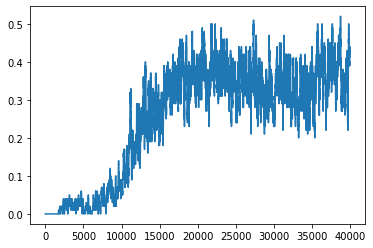

In [ ]:
plt.plot(runningAvg(episodes_reward_SARSA, windowSize=100))

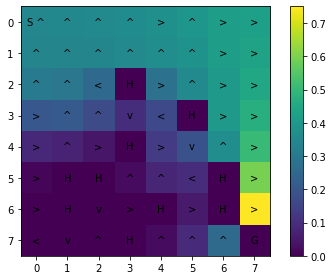

In [ ]:
plotQ(q_SARSA, 8)

In [ ]:
episodes_reward_SARSA_exploit, mean_SARSA_exploit = exploitation(env, q_SARSA, num_episodes=2000)

=====> Episode 0
=====> Episode 1000


0.742

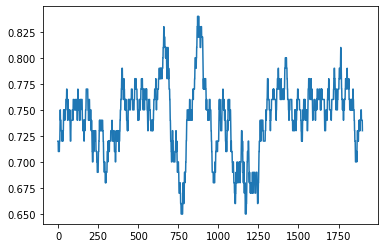

In [ ]:
plt.plot(runningAvg(episodes_reward_SARSA_exploit, windowSize=100))
mean_SARSA_exploit

## Q-learning
Implémentez l'algorithme Q-learning (en partant de SARSA, il ne devrait y avoir que quelques lignes de codes à modidier!)



In [ ]:
def qlearning(env, num_episodes, gamma=1, alpha=0.02, epsilon=0.2, verbose=False):
    
    # Initialization
    q = np.zeros((env.observation_space.n, env.action_space.n))
    episodes_reward = []
    
    # For every episode...
    for i_episode in range(num_episodes):
        
        if verbose and i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}')
            
        total_reward = 0
        state = env.reset()
        action = eps_greedy(q, state, epsilon)
        
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            #total_reward += reward
            
            if done: # new_state is terminal
                q[state, action] = q[state, action] + alpha * (reward - q[state, action])
                episodes_reward.append(reward)
                break
            else:
                best_action = np.random.choice(np.argwhere(q[state] == np.amax(q[state])).flatten().tolist())
                q[state, action] = q[state, action] + alpha * (reward + gamma*q[next_state, best_action] - q[state, action])
                next_action = eps_greedy(q, next_state, epsilon)
                
            state = next_state
            action = next_action
            #print(f'  s = {state}, a = {action}, r = {reward}, s_next = {next_state}, a_next = {next_action}')
        
    return q, episodes_reward

In [ ]:
env = gym.make("FrozenLake8x8-v0", is_slippery=True)
q_qlearn, episodes_reward_qlearn = qlearning(env, num_episodes=40000, gamma=1, alpha=0.02, epsilon=0.2, verbose=True)

=====> Episode 0
=====> Episode 1000
=====> Episode 2000
=====> Episode 3000
=====> Episode 4000
=====> Episode 5000
=====> Episode 6000
=====> Episode 7000
=====> Episode 8000
=====> Episode 9000
=====> Episode 10000
=====> Episode 11000
=====> Episode 12000
=====> Episode 13000
=====> Episode 14000
=====> Episode 15000
=====> Episode 16000
=====> Episode 17000
=====> Episode 18000
=====> Episode 19000
=====> Episode 20000
=====> Episode 21000
=====> Episode 22000
=====> Episode 23000
=====> Episode 24000
=====> Episode 25000
=====> Episode 26000
=====> Episode 27000
=====> Episode 28000
=====> Episode 29000
=====> Episode 30000
=====> Episode 31000
=====> Episode 32000
=====> Episode 33000
=====> Episode 34000
=====> Episode 35000
=====> Episode 36000
=====> Episode 37000
=====> Episode 38000
=====> Episode 39000


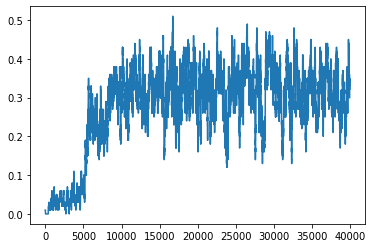

In [ ]:
plt.plot(runningAvg(episodes_reward_qlearn, windowSize=100))

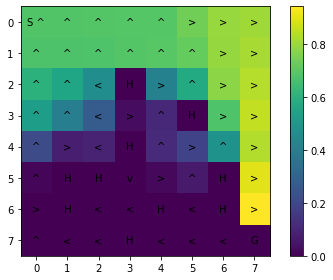

In [ ]:
plotQ(q_qlearn, 8)

In [ ]:
episodes_reward_qlearn_exploit, mean_qlearn_exploit = exploitation(env, q_qlearn, num_episodes=2000)

=====> Episode 0
=====> Episode 1000


0.775

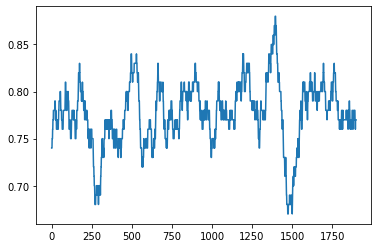

In [ ]:
plt.plot(runningAvg(episodes_reward_qlearn_exploit, windowSize=100))
mean_qlearn_exploit

## Comparaison

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

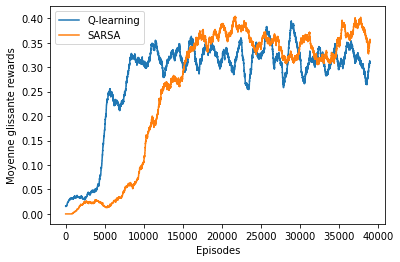

In [ ]:
plt.xlabel("Episodes")
plt.ylabel("Moyenne glissante rewards")
plt.plot(runningAvg(episodes_reward_qlearn, windowSize=1000), label="Q-learning")
plt.plot(runningAvg(episodes_reward_SARSA, windowSize=1000), label="SARSA")
plt.legend()
plt.show()

## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [ ]:
env_CP = gym.make("CartPole-v0")
print("Environnement avec", env_CP.action_space.n, "actions")
print("L'espace des états est lui codé avec une class", env_CP.observation_space,
      " qui représente un espace continu")
print("Les bornes inférieures des intervalles sont:", env_CP.observation_space.low)
print("Les bornes supérieures des intervalles sont:", env_CP.observation_space.high)
env_CP.reset()
nbIt=0
done=False
while not done:
    observation, reward, done, info = env_CP.step(np.random.randint(2))
    nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env_CP.close()

Environnement avec 2 actions
L'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
Les bornes inférieures des intervalles sont: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Les bornes supérieures des intervalles sont: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 11 itérations


In [ ]:
nval = 5 # nombre de valeurs discrètes qu’une variable peut prendre ??
N = nval**4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
print("Le nombre d'états sera ici de", N)

Le nombre d'états sera ici de 625


In [ ]:
def discretise(x, mini, maxi):
    """
        x: une des variables parmi position, velocite, angle, position haut poutre
        mini: borne inf
        maxi: borne sup
    """
    # discretise x
    # renvoie un entier entre 0 et nval-1
    if x<mini: x=mini
    if x>maxi: x=maxi
    return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
    pos = discretise(observation[0],mini=-1,maxi=1)
    vel = discretise(observation[1],mini=-1,maxi=1)
    angle = discretise(observation[2],mini=-1,maxi=1)
    pos2 = discretise(observation[3],mini=-1,maxi=1)
    return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval

Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utiliser les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement! 
Avec comme paramètre $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive a atteindre un score autour de 90 pas de temps.

In [ ]:
def SARSA_CP(env, num_episodes, n_states=N, gamma=0.9, alpha=0.2, epsilon=0.1, render=False, verbose=False):
    
    # Initialization
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions))
    episodes_reward = [] # Reward of all episodes
    
    # Starting the SARSA learning
    for i_episode in tqdm(range(num_episodes)):
        
        if verbose:
            print(f'=====> Episode {i_episode}')
            
        total_reward = 0
        
        state = env.reset()
        i_state = encode(state)
        action = eps_greedy(q, i_state, epsilon, n_actions)
        
        done = False
        while not done:
            
            # Visualizing the training
            if render:
                env.render()
            
            # Getting the next state
            next_state, reward, done, _ = env.step(action)
            i_state = encode(state)
            i_next_state = encode(next_state)
            total_reward += reward
            
            # Learning the Q-value
            if done: # new_state is terminal
                q[i_state, action] = q[i_state, action] + alpha * (reward - q[i_state, action])
                episodes_reward.append(total_reward)
                break
            else:
                next_action = eps_greedy(q, i_next_state, epsilon, n_actions)
                q[i_state, action] = q[i_state, action] + alpha * (reward + gamma*q[i_next_state, next_action] - q[i_state, action])
            
            if verbose:
                #print(f'  s={state} {i_state}, a={action}, r={reward}, s_next={next_state} {i_next_state}, a_next={next_action}')
                print(i_state, i_next_state)
                
            state = next_state
            action = next_action        
        
    return q, episodes_reward

In [ ]:
q_CP_SARSA, episodes_reward_CP_SARSA = SARSA_CP(env_CP, num_episodes=40000, verbose=False)

100%|██████████| 40000/40000 [07:32<00:00, 88.37it/s] 


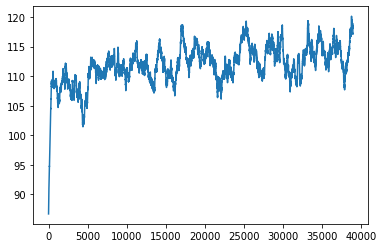

In [ ]:
plt.plot(runningAvg(episodes_reward_CP_SARSA, windowSize=1000))

In [ ]:
def exploitation_CP(env, q, num_episodes):
    
    # Initialization
    episodes_reward = []
    
    # For every episode...
    for i_episode in range(num_episodes):
        
        if i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}')
            
        total_reward = 0
        state = env.reset()
        action = np.argmax(q[encode(state)])
 
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            next_action = np.argmax(q[encode(state)])
            state = next_state
            action = next_action
            #print(f'  s = {state}, a = {action}, r = {reward}, s_next = {next_state}, a_next = {next_action}')
        
        episodes_reward.append(total_reward)
        
    return episodes_reward, np.mean(episodes_reward)

In [ ]:
episodes_reward_CP_SARSA_exploit, mean_CP_SARSA_exploit = exploitation_CP(env_CP, q_CP_SARSA, num_episodes=40000)

=====> Episode 0
=====> Episode 1000
=====> Episode 2000
=====> Episode 3000
=====> Episode 4000
=====> Episode 5000
=====> Episode 6000
=====> Episode 7000
=====> Episode 8000
=====> Episode 9000
=====> Episode 10000
=====> Episode 11000
=====> Episode 12000
=====> Episode 13000
=====> Episode 14000
=====> Episode 15000
=====> Episode 16000
=====> Episode 17000
=====> Episode 18000
=====> Episode 19000
=====> Episode 20000
=====> Episode 21000
=====> Episode 22000
=====> Episode 23000
=====> Episode 24000
=====> Episode 25000
=====> Episode 26000
=====> Episode 27000
=====> Episode 28000
=====> Episode 29000
=====> Episode 30000
=====> Episode 31000
=====> Episode 32000
=====> Episode 33000
=====> Episode 34000
=====> Episode 35000
=====> Episode 36000
=====> Episode 37000
=====> Episode 38000
=====> Episode 39000


25.351475

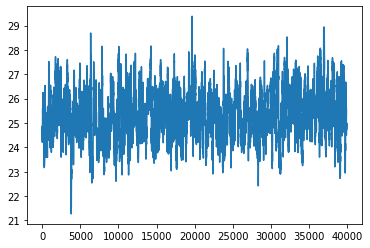

In [ ]:
plt.plot(runningAvg(episodes_reward_CP_SARSA_exploit, windowSize=100))
mean_CP_SARSA_exploit